***CLASSIFICACIÓ DE POKÉMON I DIGIMON AMB BAG OF VISUAL WORDS***

In [ ]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

from pyvis.network import Network


***LECTURA DE LES DADES***

Primerament, com tot projecte, s'inicialitzen els datasets a partir de les dades, en aquest cas les imatges dels diferents Pokémons i Digimons. S'han experimentat problemes les primeres vegades i per tant s'han afegit condicions per poder processar-les: que pesi més de 0 bytes i que tingui una terminació correcte com a format d'imatge.

In [55]:
valid_extensions = {'.jpeg', '.png', '.jpg'}

def is_valid_file(file_path):
    return os.path.splitext(file_path)[1].lower() in valid_extensions and os.path.getsize(file_path) > 0

main_folder = 'PokemonData'
data = []
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):  
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            if is_valid_file(image_path):  
                try:
                    with Image.open(image_path) as img:
                        data.append({'Pokemon': subfolder, 'Image': np.array(img)})
                except Exception as e:
                    print(f"Error procesando la imagen {image_path}: {e}")
df = pd.DataFrame(data)
print(df)

      Pokemon                                              Image
0        Abra  [[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...
1        Abra  [[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...
2        Abra  [[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...
3        Abra  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4        Abra  [[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...
...       ...                                                ...
20094   Zubat  [[[252, 252, 252], [252, 252, 252], [252, 252,...
20095   Zubat  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
20096   Zubat  [[[255, 255, 255], [255, 255, 255], [255, 255,...
20097   Zubat  [[[22, 13, 68], [23, 14, 69], [23, 14, 69], [2...
20098   Zubat  [[[255, 255, 255], [255, 255, 255], [255, 255,...

[20099 rows x 2 columns]


In [ ]:

main_folder = 'digimon'
data = []
for image_name in os.listdir(main_folder):
    image_path = os.path.join(main_folder, image_name)
    image_name = image_name.replace('.jpg', '')
    img = Image.open(image_path)
    data.append({'Digimon': image_name, 'Image': np.array(img)})
    img.close()
df_digimon = pd.DataFrame(data)
print(df_digimon)


                 Digimon                                              Image
0              Abbadomon  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1         Abbadomon_core  [[[255, 255, 255], [255, 255, 255], [255, 255,...
2            Achillesmon  [[[255, 255, 255], [255, 255, 255], [255, 255,...
3           Aegiochusmon  [[[255, 255, 255], [255, 255, 255], [255, 255,...
4     Aegiochusmon_blue2  [[[255, 255, 255], [255, 255, 255], [255, 255,...
...                  ...                                                ...
1122         Zhuqiaomon2  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1123        Zubaeagermon  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1124             Zubamon  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1125             Zudomon  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1126             Zurumon  [[[255, 255, 255], [255, 255, 255], [255, 255,...

[1127 rows x 2 columns]


No totes les imatges tenen les mateixes dimensions, i per tant es fa un resize a unes dimensions més accessibles pel que fa al processament de les matrius d'imatges.

In [57]:
output_size = (128, 128) 
df['Image'] = df['Image'].apply(lambda img: cv2.resize(img, output_size))
df['Index'] = df.index
df_digimon['Image'] = df_digimon['Image'].apply(lambda img: cv2.resize(img, output_size))

Fixem una seed o llavor per tal de poder reproduïr els processos sense dependre de l'aleatorietat de com s'agafen les dades. A més, es divideix ja el dataset dels digimons per la meitat, per tal de crear un train i un test.

In [ ]:
seed = 24
np.random.seed(seed)

train_digimon = df_digimon.sample(frac=0.5, random_state=seed).reset_index(drop=True)
test_digimon = df_digimon.drop(train_digimon.index).reset_index(drop=True)

Es defineixen funcions per evitar que aparegui el procés de Bag of Visual Words repetit constantment

In [ ]:
def encode_bovw(descriptors, visual_words):
    histogram = np.zeros(len(visual_words))
    distances = cdist(descriptors, visual_words)
    nearest_clusters = np.argmin(distances, axis=1)
    for cluster_idx in nearest_clusters:
        histogram[cluster_idx] += 1
    return histogram

def find_descriptors_and_no_keypoints_images(images, extractor, step_size=None):
    descriptors = []
    no_keypoints = []
    idx = 0
    if step_size is None:
        for image in images:
            _, descriptor = extractor.detectAndCompute(image, None)
            if descriptor is not None:  
                descriptors.append(descriptor)
            else:
                no_keypoints.append(idx)
                print(f'Image {idx} from train has no keypoints')
            idx += 1
    else:
        for image in images:
            keypoints = [cv2.KeyPoint(x, y, step_size)
                        for y in range(0, image.shape[0], step_size)
                        for x in range(0, image.shape[1], step_size)]
            _, descriptor = extractor.compute(image, keypoints)
            if descriptor is not None:
                descriptors.append(descriptor)
            else:
                no_keypoints.append(idx)
        idx += 1
    return descriptors, no_keypoints

def get_visual_words (descriptors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=24)
    kmeans.fit(descriptors)
    return kmeans.cluster_centers_

def normalise_histograms(descriptors, visual_words):
    histograms = np.array([encode_bovw(desc, visual_words) for desc in descriptors])
    return histograms / np.sum(histograms, axis=1, keepdims=True)

def combine_pokemon_digimon(X_train_pokemon, X_test_pokemon, X_train_digimon, X_test_digimon):
    y_train_pokemon = np.zeros(len(X_train_pokemon))
    y_test_pokemon = np.zeros(len(X_test_pokemon))
    y_train_digimon = np.ones(len(X_train_digimon))
    y_test_digimon = np.ones(len(X_test_digimon))
    X_combined_train = np.vstack((X_train_pokemon, X_train_digimon))
    y_combined_train = np.concatenate((y_train_pokemon, y_train_digimon))
    X_combined_test = np.vstack((X_test_pokemon, X_test_digimon))
    y_combined_test = np.concatenate((y_test_pokemon, y_test_digimon))
    X_combined_train_shuffled, y_combined_train_shuffled = shuffle(X_combined_train, y_combined_train, random_state=seed)
    X_combined_test_shuffled, y_combined_test_shuffled = shuffle(X_combined_test, y_combined_test, random_state=seed)
    return X_combined_train_shuffled, y_combined_train_shuffled, X_combined_test_shuffled, y_combined_test_shuffled


S'agafen 4 pokémons de cada classe per tal que el X_Train sigui aproximadament 50% Pokémon i 50% Digimon. Posteriorment, a partir de les imatges i les funcions definides que implementen el Bag of Visual Words, es generen els histogrames necessaris que es fan servir com X_train y es generen el vector de y per les labels predictives. En aquest cas s'aplica el SIFT i Logistic Regression

C:\Users\druiz\AppData\Local\Temp\ipykernel_24700\2541098553.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df.groupby('Pokemon').apply(lambda x: x.sample(4, random_state=seed)).reset_index(drop=True)


Image 5976 from train has no keypoints
Accuracy: 0.8533679014807798
              precision    recall  f1-score   support

     Pokemon       0.99      0.85      0.92     19494
     Digimon       0.14      0.81      0.24       563

    accuracy                           0.85     20057
   macro avg       0.57      0.83      0.58     20057
weighted avg       0.97      0.85      0.90     20057



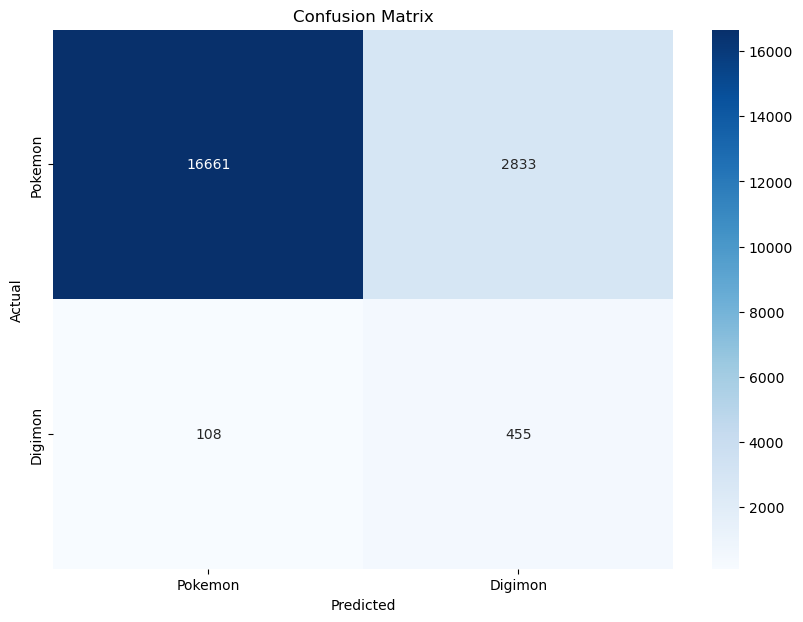

In [60]:
train = df.groupby('Pokemon').apply(lambda x: x.sample(4, random_state=seed)).reset_index(drop=True)
test = df[~df['Index'].isin(train['Index'])]

extractor = cv2.SIFT_create()

descriptors_train, no_keypoints_train = find_descriptors_and_no_keypoints_images(train['Image'], extractor)
descriptors_test, no_keypoints_test = find_descriptors_and_no_keypoints_images(test['Image'], extractor)
descriptors_digimon, no_keypoints_digimon = find_descriptors_and_no_keypoints_images(train_digimon['Image'], extractor)
descriptors_digimon_test, no_keypoints_digimon_test = find_descriptors_and_no_keypoints_images(test_digimon['Image'], extractor)

all_descriptors_pokemon = np.vstack(descriptors_train)
all_descriptors_digimon = np.vstack(descriptors_digimon)

num_clusters = 300

all_descriptors = np.vstack((all_descriptors_pokemon, all_descriptors_digimon))
visual_words = get_visual_words(all_descriptors, num_clusters)

X_train = normalise_histograms(descriptors_train, visual_words)
X_test = normalise_histograms(descriptors_test, visual_words)
X_digimon = normalise_histograms(descriptors_digimon, visual_words)
X_digimon_test = normalise_histograms(descriptors_digimon_test, visual_words)

X_combined_train, y_combined_train, X_combined_test, y_combined_test = combine_pokemon_digimon(X_train, X_test, X_digimon, X_digimon_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_combined_train, y_combined_train)

y_pred_log_reg = log_reg.predict(X_combined_test)

accuracy_log_reg = accuracy_score(y_combined_test, y_pred_log_reg)
print(f"Accuracy: {accuracy_log_reg}")

print(classification_report(y_combined_test, y_pred_log_reg, target_names=['Pokemon', 'Digimon']))


cm = confusion_matrix(y_combined_test, y_pred_log_reg)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pokemon', 'Digimon'], yticklabels=['Pokemon', 'Digimon'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Aquest codi és el mateix a excepció de que s'afageix un step_size per dur a terme el Dense_SIFT

Accuracy: 0.7808355768272012
              precision    recall  f1-score   support

     Pokemon       1.00      0.78      0.87     19495
     Digimon       0.11      0.96      0.20       563

    accuracy                           0.78     20058
   macro avg       0.55      0.87      0.54     20058
weighted avg       0.97      0.78      0.85     20058



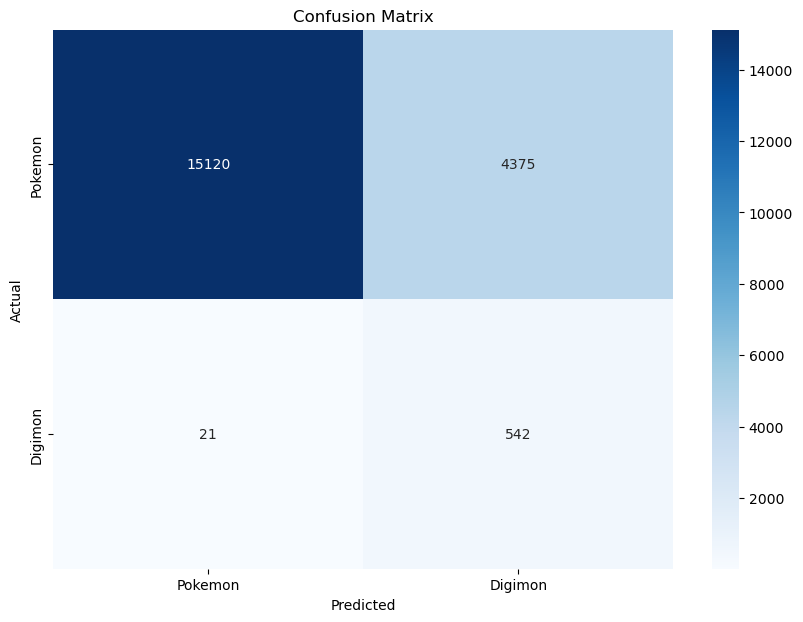

In [61]:
extractor = cv2.SIFT_create()

step_size = 8

descriptors_train, no_keypoints_train = find_descriptors_and_no_keypoints_images(train['Image'], extractor, step_size)
descriptors_test, no_keypoints_test = find_descriptors_and_no_keypoints_images(test['Image'], extractor, step_size)
descriptors_digimon, no_keypoints_digimon = find_descriptors_and_no_keypoints_images(train_digimon['Image'], extractor, step_size)
descriptors_digimon_test, no_keypoints_digimon_test = find_descriptors_and_no_keypoints_images(test_digimon['Image'], extractor, step_size)

all_descriptors_pokemon = np.vstack(descriptors_train)
all_descriptors_digimon = np.vstack(descriptors_digimon)

num_clusters = 300

all_descriptors = np.vstack((all_descriptors_pokemon, all_descriptors_digimon))
visual_words = get_visual_words(all_descriptors, num_clusters)

X_train = normalise_histograms(descriptors_train, visual_words)
X_test = normalise_histograms(descriptors_test, visual_words)
X_digimon = normalise_histograms(descriptors_digimon, visual_words)
X_digimon_test = normalise_histograms(descriptors_digimon_test, visual_words)

X_combined_train, y_combined_train, X_combined_test, y_combined_test = combine_pokemon_digimon(X_train, X_test, X_digimon, X_digimon_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_combined_train, y_combined_train)

y_pred_log_reg = log_reg.predict(X_combined_test)

accuracy_log_reg = accuracy_score(y_combined_test, y_pred_log_reg)
print(f"Accuracy: {accuracy_log_reg}")

print(classification_report(y_combined_test, y_pred_log_reg, target_names=['Pokemon', 'Digimon']))


cm = confusion_matrix(y_combined_test, y_pred_log_reg)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pokemon', 'Digimon'], yticklabels=['Pokemon', 'Digimon'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Visualització de les features amb PCA

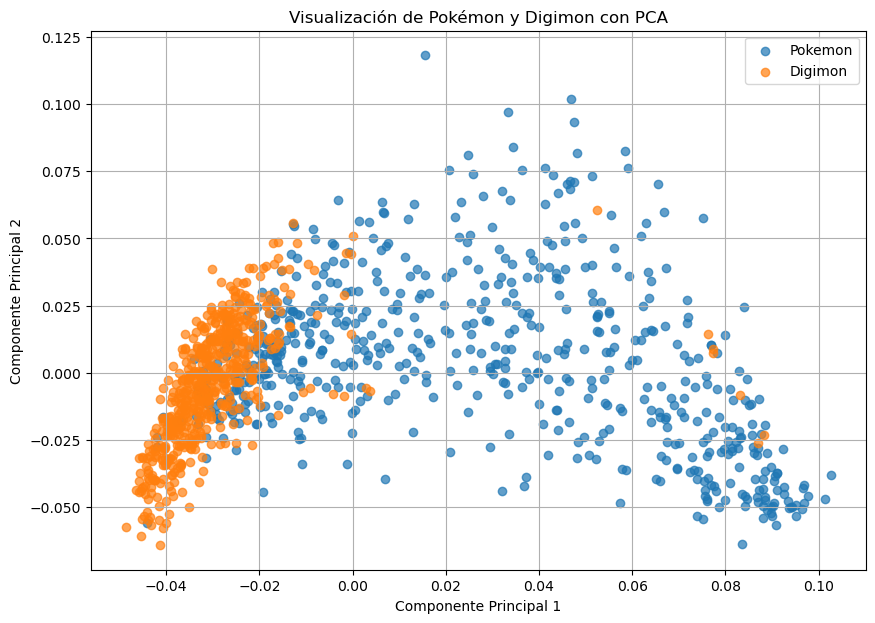

In [ ]:

pca = PCA(n_components=2)
X_combined_pca = pca.fit_transform(X_combined_train)

plt.figure(figsize=(10, 7))

plt.scatter(
    X_combined_pca[y_combined_train == 0, 0],
    X_combined_pca[y_combined_train == 0, 1],
    label='Pokemon',
    alpha=0.7
)
plt.scatter(
    X_combined_pca[y_combined_train == 1, 0],
    X_combined_pca[y_combined_train == 1, 1],
    label='Digimon',
    alpha=0.7
)
plt.title('Visualización de Pokémon y Digimon con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


***BÚSQUEDA D'HIPERPARÀMETRES***

In [63]:
train = df.groupby('Pokemon').apply(lambda x: x.sample(50, random_state=seed)).reset_index(drop=True)
test = df[~df['Index'].isin(train['Index'])]

descriptors_train, no_keypoints_train = find_descriptors_and_no_keypoints_images(train['Image'], extractor)
descriptors_test, no_keypoints_test = find_descriptors_and_no_keypoints_images(test['Image'], extractor)

all_descriptors = np.vstack(descriptors_train)
num_clusters = 300
visual_words = get_visual_words(all_descriptors, num_clusters)

X_train = normalise_histograms(descriptors_train, visual_words)
X_test = normalise_histograms(descriptors_test, visual_words)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['Pokemon'])
y_test = label_encoder.transform(test['Pokemon'])

y_test = np.delete(y_test, no_keypoints_test)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

svm_model = SVC()

grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=5, 
    verbose=2, 
    scoring='accuracy', 
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)


C:\Users\druiz\AppData\Local\Temp\ipykernel_24700\2658996435.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df.groupby('Pokemon').apply(lambda x: x.sample(50, random_state=seed)).reset_index(drop=True)


Image 3766 from train has no keypoints
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best accuracy score:  0.21827814569536425


***CLASSIFICACIÓ SEGONS LA ESPÈCIE POKÉMON I VISUALITZACIÓ DE RESULTATS AMB ROC CURVE***

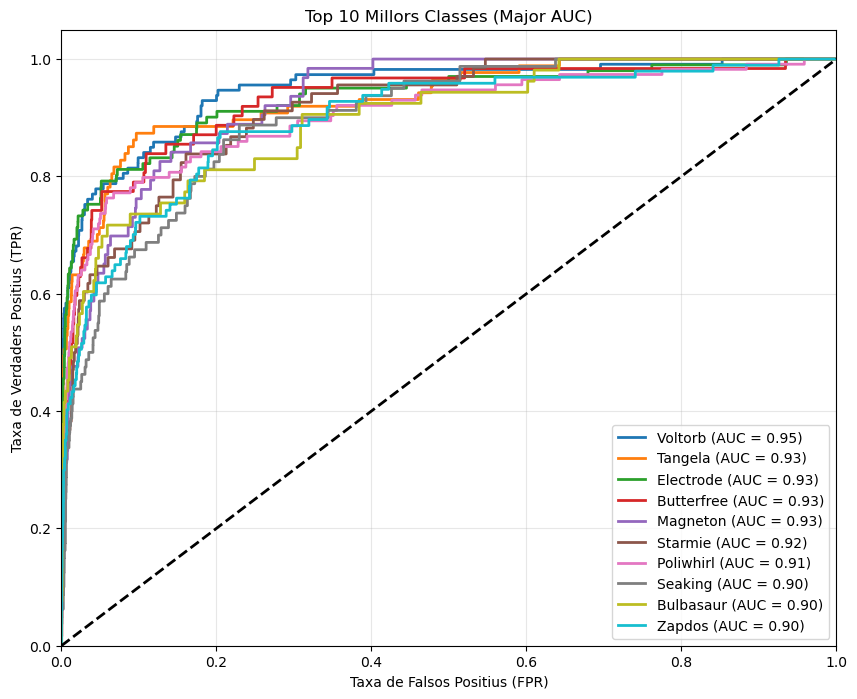

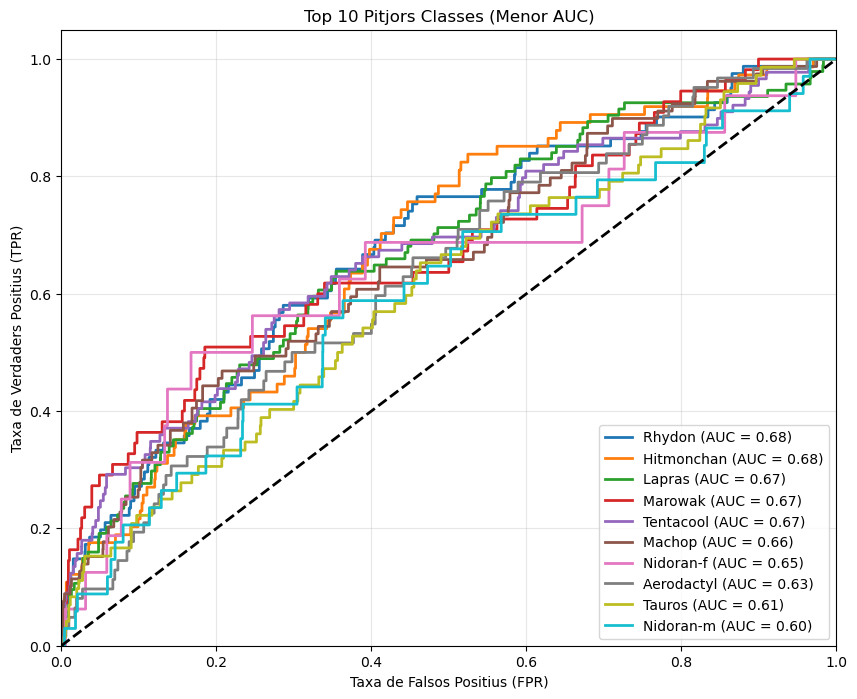

In [ ]:
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

sorted_auc = sorted(roc_auc.items(), key=lambda x: x[1], reverse=True)
top_10_best = sorted_auc[:10]
top_10_worst = sorted_auc[-10:]
species_names = label_encoder.inverse_transform([class_idx for class_idx, _ in top_10_best + top_10_worst])

class_to_species = {class_idx: species_name for class_idx, species_name in zip([class_idx for class_idx, _ in top_10_best + top_10_worst], species_names)}

def plot_roc_curve(classes, title):
    plt.figure(figsize=(10, 8))
    for class_idx, auc_value in classes:
        species_name = class_to_species[class_idx]
        plt.plot(fpr[class_idx], tpr[class_idx], lw=2, label=f'{species_name} (AUC = {auc_value:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positius (FPR)')
    plt.ylabel('Taxa de Verdaders Positius (TPR)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_roc_curve(top_10_best, 'Top 10 Millors Classes (Major AUC)')
plot_roc_curve(top_10_worst, 'Top 10 Pitjors Classes (Menor AUC)')


***CODI PER CREAR 2 GRAFS: UN GRAF AMB TOTS ELS DIGIMONS I UN ALTRE MOLT MÉS REDUÏT***

In [65]:
from sklearn.svm import SVC

digimon_names = df_digimon['Digimon']

best_svm_model = SVC(C=100, gamma=1, kernel='rbf', probability=True)
best_svm_model.fit(X_train, y_train)

digimon_predictions = best_svm_model.predict(X_test)  
digimon_probabilities = best_svm_model.predict_proba(X_test)

predicted_species = label_encoder.inverse_transform(digimon_predictions)

In [ ]:
pokemon_species = label_encoder.classes_ 

num_digimon_to_display = 50  
subset_indices = random.sample(range(len(digimon_names)), num_digimon_to_display)

subset_digimon_names = [digimon_names[i] for i in subset_indices]
subset_digimon_probabilities = [digimon_probabilities[i] for i in subset_indices]

net = Network(height="750px", width="100%", notebook=True)
net.barnes_hut()  

for species in pokemon_species:
    net.add_node(species, label=species, color="lightblue", size=20)

for i, digimon_name in enumerate(subset_digimon_names):
    top_indices = subset_digimon_probabilities[i].argsort()[-3:][::-1]  
    top_species = [pokemon_species[idx] for idx in top_indices]
    net.add_node(digimon_name, label=digimon_name, color="orange", size=10)
    for species in top_species:
        net.add_edge(digimon_name, species)

net.show("digimon_pokemon_graph.html")

digimon_pokemon_graph.html
El grafo interactivo ha sido generado y guardado como 'digimon_pokemon_graph.html'.


In [ ]:
valid_extensions = ['.jpg', '.png', '.JPG', '.jpeg', '.gif']

digimon_folder = "digimon"

digimon_images = {}
for name in digimon_names:
    found_image = None
    for ext in valid_extensions:
        image_path = os.path.join(digimon_folder, f"{name}{ext}")
        if os.path.exists(image_path):
            found_image = image_path
            break
    digimon_images[name] = found_image


pokemon_folder = "PokemonData"
pokemon_images = {}

for species in pokemon_species:
    species_folder = os.path.join(pokemon_folder, species)
    if os.path.exists(species_folder):
        image_files = [f for f in os.listdir(species_folder) if f.endswith(('.jpg', '.png', '.JPG', '.jpeg', '.gif'))]
        if image_files:
            pokemon_images[species] = os.path.join(species_folder, image_files[0])
        else:
            pokemon_images[species] = None 
    else:
        pokemon_images[species] = None 
        
num_digimon_to_display = 50  
subset_indices = random.sample(range(len(digimon_names)), num_digimon_to_display)

subset_digimon_names = [digimon_names[i] for i in subset_indices]
subset_digimon_probabilities = [digimon_probabilities[i] for i in subset_indices]

net = Network(height="750px", width="100%", notebook=True)
net.barnes_hut()  
for species, image_path in pokemon_images.items():
    if image_path:  
        net.add_node(species, label=species,shape="image",image=image_path,)
    else:
        net.add_node(species,label=species,color="blue",)

for i, digimon_name in enumerate(subset_digimon_names):
    top_indices = subset_digimon_probabilities[i].argsort()[-3:][::-1] 
    top_species = [pokemon_species[idx] for idx in top_indices]
    image_path = digimon_images.get(digimon_name)
    if image_path: 
        net.add_node(digimon_name,label=digimon_name,shape="image",image=image_path,)
    else:
        net.add_node(digimon_name,label=digimon_name,color="orange",)
    for species in top_species:
        net.add_edge(digimon_name, species)

net.show("digimon_pokemon_minigraph.html")

digimon_pokemon_minigraph.html


In [ ]:


net = Network(height="750px", width="100%", notebook=True)
net.barnes_hut() 

for species, image_path in pokemon_images.items():
    if image_path:
        net.add_node(
            species,
            label=species,
            shape="image",
            image=image_path,
        )
    else:
        net.add_node(
            species,
            label=species,
            color="blue",
        )

for i, digimon_name in enumerate(digimon_names):
    top_indices = digimon_probabilities[i].argsort()[-3:][::-1]
    top_species = [pokemon_species[idx] for idx in top_indices]
    image_path = digimon_images.get(digimon_name)
    if image_path:
        net.add_node(
            digimon_name,
            label=digimon_name,
            shape="image",
            image=image_path,
        )
    else:
        net.add_node(
            digimon_name,
            label=digimon_name,
            color="orange",
        )
    for species in top_species:
        net.add_edge(digimon_name, species)

net.show("digimon_pokemon_graph.html")


digimon_pokemon_graph.html
